# Traffic Flow Dataset
- This dataset is provided by South Dublin County Council
- The dataset includes traffic congestion data collected at a number of sites in south county Dublin from January - June 2022
Data Sources
1. https://data.gov.ie/dataset/traffic-flow-data-jan-to-june-2022-sdcc1
2. https://data.gov.ie/dataset/traffic-data-site-names-sdcc1


# Imports

In [188]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import folium
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Read in Data
Two csv files are available:
1. Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv: Has information on traffic flow at various locations
2. Traffic_Data_Site_Names_SDCC.csv: Gives more information on the locations the traffic flow data is being collected from


In [189]:
traffic_flow_data = pd.read_csv('data/Traffic_Flow_Data_Jan_to_June_2022_SDCC.csv')
traffic_junctions_data = pd.read_csv('data/Traffic_Data_Site_Names_SDCC.csv')

# EDA - Let's understand the data better

## Traffic_Flow_Data_Jan_to_June_2022_SDCC

In [190]:
traffic_flow_data.head()

,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc,ObjectId
0,N01111A,TU,04/01/2022,2022/11/07 03:00:00+00,03:15,13,100,0,100,0,0,1
1,N01111A,TU,04/01/2022,2022/11/07 03:15:00+00,03:30,10,100,0,100,0,0,2
2,N01111A,TU,04/01/2022,2022/11/07 03:30:00+00,03:45,0,100,0,100,0,0,3
3,N01111A,TU,04/01/2022,2022/11/07 03:45:00+00,04:00,9,100,0,100,0,0,4
4,N01111A,TU,04/01/2022,2022/11/07 04:00:00+00,04:15,0,100,0,100,0,0,5


In [191]:
print(f'Dataset has {len(traffic_flow_data):,} rows')

Dataset has 1,048,575 rows


### Columns explanations
1. "site": This is the ID of the side at which the congestion was collected (More information on these sites given in the second dataset)
2. "day": This is the day on which the data was collected
3. "date" This is the date on which the the data was collected
4. "start_time": Congestion is collected over 15 minute intervals. This is the start time of this 15 minute interval
5. "end_time": Congestion is collected over 15 minute intervals. This is the end time of this 15 minute interval
6. "flow": Represents the demand (traffic flow) at each site. This is calculated by the SCOOT model, which measures the volume of traffic over several minutes. It has two profiles:
    - Short: Raw data showing real-time values over the last few minutes.
    - Long: Smoothed average values over a longer period. The system uses the appropriate profile depending on the situation.
7. "cong": Measures congestion by detecting standing traffic. When stationary traffic is detected for an entire interval, it is considered a congested interval. The system records how many intervals experienced congestion in a cycle.
8. "cong_pc": The percentage of congestion, calculated based on the number of congested intervals relative to the total cycle time. This gives an idea of how much of the time the site was congested.
9. "dsat": Degree of saturation, which is the ratio of the actual traffic demand flow to the maximum possible discharge flow (saturation flow). It indicates how full the traffic system is. The Split optimizer tries to minimize the maximum degree of saturation on links approaching the node.
10. "dsat_pc": Likely represents the degree of saturation as a percentage, giving a proportional view of how saturated a site is relative to its maximum capacity.
11. "ObjectId": Each data entry is given a unique ID

- SCOOT (Split Cycle Offset Optimization Technique) is a traffic control system used for real-time optimization of traffic signals in urban areas. See more on wikipedia https://en.wikipedia.org/wiki/Split_Cycle_Offset_Optimisation_Technique 

### Data Cleaning and Preparation
The data source mentions the date in the "start_time" column is incorrect so let's fix that and ensure the correct date formats for the other columns

#### Check for NULL entries

In [192]:
null_mask = traffic_flow_data.isnull().any(axis=1)
null_rows = traffic_flow_data[null_mask]
print(f"There are {len(null_rows)} NULL entries")

There are 0 NULL entries


Convert to date times where necessary

In [193]:
traffic_flow_data['start_time'] = pd.to_datetime(traffic_flow_data['start_time'])
traffic_flow_data['start_time'] = traffic_flow_data['start_time'].dt.time

traffic_flow_data['date'] = pd.to_datetime(traffic_flow_data['date'], format='mixed')


Some end times are "24:00" instead of "00:00: so this must be fixed

In [194]:
mask_24h = traffic_flow_data['end_time'].str.contains('24:00')
traffic_flow_data.loc[mask_24h, 'end_time'] = '00:00'
traffic_flow_data['end_time'] = pd.to_datetime(traffic_flow_data['end_time']).dt.time
traffic_flow_data.head()

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_40392/3518518268.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc,ObjectId
0,N01111A,TU,2022-04-01,03:00:00,03:15:00,13,100,0,100,0,0,1
1,N01111A,TU,2022-04-01,03:15:00,03:30:00,10,100,0,100,0,0,2
2,N01111A,TU,2022-04-01,03:30:00,03:45:00,0,100,0,100,0,0,3
3,N01111A,TU,2022-04-01,03:45:00,04:00:00,9,100,0,100,0,0,4
4,N01111A,TU,2022-04-01,04:00:00,04:15:00,0,100,0,100,0,0,5


Seems that some dates go beyond June. Given the dataset says it is only from January to June we will remove those

In [195]:
traffic_flow_data = traffic_flow_data[(traffic_flow_data['date'] >= '2022-01-01') & (traffic_flow_data['date'] <= '2022-06-30')]


## Traffic_Data_Site_Names_SDCC

In [196]:
traffic_junctions_data.head()

,OBJECTID,scn,region,system,locn,X,Y
0,1,N01111,RGA,A,Airton GrHill,-6.356151,53.293594
1,2,N01121,RGR,A,Mayberry GrHill,-6.354352,53.298306
2,3,N01131,RGR,A,Tymon North,-6.352204,53.301229
3,4,N01141,RGR,A,Cuckoos Nest,-6.352882,53.303248
4,5,N01151,RGA,A,Harvey Grhills,-6.355703,53.294523


-  <b> Key point: We only have data from system A -> Just use sites that end in A from traffic flows </b>
- lets then create a column for the sites we have available in this dataset

In [197]:
traffic_junctions_data['site'] = traffic_junctions_data['scn']+traffic_junctions_data['system']
traffic_junctions_data.head()

,OBJECTID,scn,region,system,locn,X,Y,site
0,1,N01111,RGA,A,Airton GrHill,-6.356151,53.293594,N01111A
1,2,N01121,RGR,A,Mayberry GrHill,-6.354352,53.298306,N01121A
2,3,N01131,RGR,A,Tymon North,-6.352204,53.301229,N01131A
3,4,N01141,RGR,A,Cuckoos Nest,-6.352882,53.303248,N01141A
4,5,N01151,RGA,A,Harvey Grhills,-6.355703,53.294523,N01151A


Get the common sites available via an inner join

In [198]:
traffic_junctions_data['site'] = traffic_junctions_data['site'].astype(str)
traffic_flow_data['site'] = traffic_flow_data['site'].astype(str)

merged_data = traffic_junctions_data.merge(traffic_flow_data, on='site', how='inner')
merged_data.drop(columns=['OBJECTID', 'ObjectId', 'system'], inplace=True)
merged_data.head()

,scn,region,locn,X,Y,site,day,date,start_time,end_time,flow,flow_pc,cong,cong_pc,dsat,dsat_pc
0,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:00:00,03:15:00,13,100,0,100,0,0
1,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:15:00,03:30:00,10,100,0,100,0,0
2,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:30:00,03:45:00,0,100,0,100,0,0
3,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,03:45:00,04:00:00,9,100,0,100,0,0
4,N01111,RGA,Airton GrHill,-6.356151,53.293594,N01111A,TU,2022-04-01,04:00:00,04:15:00,0,100,0,100,0,0


## Merged Data

### Understand the sites

In [199]:
pd.DataFrame(merged_data['site'].value_counts())

,count
site,
N01111A,13917
N01151A,13917
N02111A,13917
N02131A,13917
N03121A,13917
N01131A,13916


Let's have a look on the map at these locations

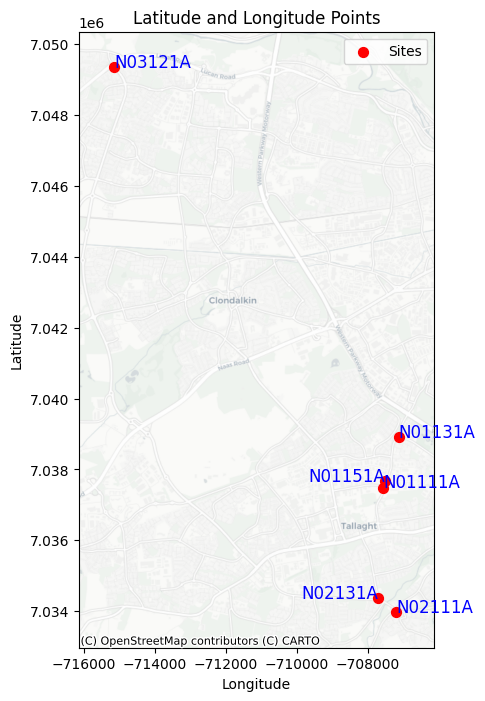

In [200]:
# Create the DataFrame
unique_locations = merged_data[['X', 'Y', 'site']].drop_duplicates()

df = pd.DataFrame(unique_locations)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X'], df['Y']))

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Convert to Web Mercator for basemap
gdf = gdf.to_crs(epsg=3857)

# Create a plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the points
gdf.plot(ax=ax, color='red', markersize=50, label='Sites')

# Add a basemap using contextily
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set title and labels
plt.title("Latitude and Longitude Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Zoom out by adjusting the limits
x_buffer = 1e3  # Adjust this value for more or less zoom out
y_buffer = 1e3  # Adjust this value for more or less zoom out

ax.text(-707563.5149890548, 7037490.645134047, 'N01111A', fontsize=12, ha='left', color='blue')
ax.text(-707513.6438571794, 7037663.702918401, 'N01151A', fontsize=12, ha='right', color='blue')
ax.text(-707124.1035630464 ,7038912.691295063, 'N01131A', fontsize=12, ha='left', color='blue')
ax.text(-707701.8183244163, 7034367.926777995, 'N02131A', fontsize=12, ha='right', color='blue')
ax.text(-707207.4707297016, 7033971.695090625, 'N02111A', fontsize=12, ha='left', color='blue')
ax.text(-715151.3075163532, 7049345.7970557455, 'N03121A', fontsize=12, ha='left', color='blue')

plt.xlim(gdf.total_bounds[[0, 2]][0] - x_buffer, gdf.total_bounds[[0, 2]][1] + x_buffer)  # x limits
plt.ylim(gdf.total_bounds[[1, 3]][0] - y_buffer, gdf.total_bounds[[1, 3]][1] + y_buffer)  # y limits

# plt.grid()
plt.legend()
plt.show()


In [201]:
unique_locations

,X,Y,site
0,-6.356151,53.293594,N01111A
13917,-6.352204,53.301229,N01131A
27833,-6.355703,53.294523,N01151A
41750,-6.352953,53.274696,N02111A
55667,-6.357394,53.276824,N02131A
69584,-6.424314,53.357202,N03121A


#### Observations
- We can see from the map that there is a cluster of 5 points together with the 6th point isolated from the other 5.
- We would expect to see a close correlation in flow and congestion between the sites closer together, especially N01151A and N01111A which are very close together

We will also create another map view to more closely inspect the points

In [202]:
gdf = gdf.to_crs(epsg=4326)

m = folium.Map(location=[53.293594,-6.356151], zoom_start=10)
for _, row in gdf.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius = 5,
        fill = True,
        fill_opacity = 0.7,
        popup=f"Site: {row['site']}",
        color = 'red'

    ).add_to(m)
folium.LayerControl().add_to(m)
m

## Investigate traffic flow trends

#### Traffic over time period of the data

In [203]:
merged_data['year_month'] = merged_data['date'].dt.to_period('M').astype(str)  # Create a year-month column
monthly_flow = merged_data.groupby('year_month')['flow'].sum().reset_index()
monthly_flow


,year_month,flow
0,2022-01,3563819
1,2022-02,2641741
2,2022-03,3099993
3,2022-04,3046575
4,2022-05,3266543
5,2022-06,3015927


In [204]:
month_fig = go.Figure(data=go.Bar(x=monthly_flow['year_month'].astype(dtype=str), 
                        y=monthly_flow['flow'],
                        marker_color='indianred'))
month_fig.update_layout({"title": 'Traffic flow across all sites from January to June 2022',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
month_fig.show()


Observations
- January definetly seems to be the month with the highest flow volumes however in general they tend to stay pretty consistent 
- February, April and June all have lower flow volumnes however it should be kept in mind that these are all months with shorter days. 
    - <b> Lets normalise the data by the number of days in that month then to get a better view </b>

In [205]:
monthly_flow['days_in_month'] = pd.to_datetime(monthly_flow['year_month']).dt.days_in_month

# Step 4: Normalize the flow by dividing the total flow by the number of days in each month
monthly_flow['normalized_flow'] = monthly_flow['flow'] / monthly_flow['days_in_month']
monthly_flow.head()


,year_month,flow,days_in_month,normalized_flow
0,2022-01,3563819,31,114961.903226
1,2022-02,2641741,28,94347.892857
2,2022-03,3099993,31,99999.774194
3,2022-04,3046575,30,101552.500000
4,2022-05,3266543,31,105372.354839


In [206]:
month_fig = go.Figure(data=go.Bar(x=monthly_flow['year_month'].astype(dtype=str), 
                        y=monthly_flow['normalized_flow'],
                        marker_color='indianred'))
month_fig.update_layout({"title": 'Traffic flow across all sites from January to June 2022',
                   "xaxis": {"title":"Months"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
month_fig.show()


- This figure gives a clearer view on the traffic flow per month with January still dominating however less variability in the total flow in the other months
- <b>Note:</b> Other factors such as public holidays and number of weekends in a month could explain total flow variability however we will not delve deeper into this in this analysis

#### Traffic over each site

In [207]:
flow_by_site = merged_data.groupby('site')['flow'].sum().reset_index()
flow_by_site


,site,flow
0,N01111A,3255878
1,N01131A,795600
2,N01151A,2759738
3,N02111A,4907734
4,N02131A,3606761
5,N03121A,3308887


In [208]:
site_fig = go.Figure(data=go.Bar(x=flow_by_site['site'].astype(dtype=str), 
                        y=flow_by_site['flow'],
                        marker_color='indianred'))
site_fig.update_layout({"title": 'Traffic flow across all sites',
                   "xaxis": {"title":"Sites"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
site_fig.show()


Observations
- Site N02111A has the most flow and N01121A has the least
- There is quite a bit of variability in traffic flow in sites especially when compared to the variability we saw by month 


#### Traffic per site per month

In [209]:
monthly_flow_grouped = merged_data.groupby(['year_month', 'site'])['flow'].sum().reset_index()
monthly_flow_grouped['days_in_month'] = pd.to_datetime(monthly_flow_grouped['year_month']).dt.days_in_month
# Step 4: Normalize the flow by dividing the total flow by the number of days in each month
monthly_flow_grouped['normalized_flow'] = monthly_flow_grouped['flow'] / monthly_flow_grouped['days_in_month']
monthly_flow_grouped

,year_month,site,flow,days_in_month,normalized_flow
0,2022-01,N01111A,539418,31,17400.580645
1,2022-01,N01131A,562980,31,18160.645161
2,2022-01,N01151A,460298,31,14848.322581
3,2022-01,N02111A,832346,31,26849.870968
4,2022-01,N02131A,608751,31,19637.129032
5,2022-01,N03121A,560026,31,18065.354839
6,2022-02,N01111A,478193,28,17078.321429
7,2022-02,N01131A,44708,28,1596.714286
8,2022-02,N01151A,404030,28,14429.642857
9,2022-02,N02111A,721555,28,25769.821429


In [210]:
fig = go.Figure()

for site in unique_locations['site']:
    site_data = monthly_flow_grouped[monthly_flow_grouped['site'] == site]
    fig.add_trace(go.Scatter(
        x=site_data['year_month'].astype(dtype=str),
        y=site_data['normalized_flow'],
        name=site,
    ))

# Update layout
fig.update_layout(
    title='Traffic flow across all sites from January to June 2022',
    xaxis_title="Months",
    yaxis_title="Total Flow",
    showlegend=True
)

# Show the figure
fig.show()

Observations
- The flow volumes are relatively consistent throughout months in most the sites
- We see a sharp drop in the flow in site N01121A from January to February and then it remains relatively consistent
    - Assuming no data quality issues, this could indicate possible roadworks or a change in traffic patterns in this site
    - We should note that flow in this site in January should be considered an <b>outlier</b> 

### Traffic as a function of the day of the week
We can all imagine that time will play a key factor in traffic flow due to rush hour and the difference in weekdays and weekends... Let's investigate!

#### Traffic Flow as a function of day of the week

##### Firstly for all sites

In [211]:
day_mapping = {
    'MO': 0,  # Monday
    'TU': 1,  # Tuesday
    'WE': 2,  # Wednesday
    'TH': 3,  # Thursday
    'FR': 4,  # Friday
    'SA': 5,  # Saturday
    'SU': 6   # Sunday
}
merged_data['day_ind'] = merged_data['day'].map(day_mapping)
flow_by_day = merged_data.groupby(['day_ind', 'day'])['flow'].sum().reset_index().sort_values('day_ind')
flow_by_day


,day_ind,day,flow
0,0,MO,2620833
1,1,TU,2720913
2,2,WE,2916259
3,3,TH,2935139
4,4,FR,2908931
5,5,SA,2407443
6,6,SU,2125080


In [212]:
fig = go.Figure(data=go.Bar(x=flow_by_day['day'].astype(dtype=str), 
                        y=flow_by_day['flow'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Traffic flow across all sites by day of the week',
                   "xaxis": {"title":"Day of Week"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
fig.show()


Observations
- Wednesday and Thursday are the two highest days... Probably the two most popular days to go into the office!
- We see less traffic on the weekends and Sunday being the quitest day for traffic

#### Traffic as a function of time
Finally.. probably the biggest indicator of traffic flow from personal experience is the time of day. Let's see what the data is telling us
- First, 15 minute intervals are quite short
     - Let's aggregate the data to get a view of traffic flow by hour instead

In [221]:
merged_data['start_time'] = pd.to_datetime(merged_data['start_time'], format='%H:%M:%S')

# Resample the flow data by hour without setting the index
hourly_flow = merged_data.groupby(pd.Grouper(key='start_time', freq='h'))['flow'].mean().reset_index()

# If you want to keep only the time part in the index:
hourly_flow['time'] = hourly_flow['start_time'].dt.time
hourly_flow.drop(columns=['start_time'], inplace=True)
# Display the hourly flow
hourly_flow


,flow,time
0,39.398563,00:00:00
1,26.009535,01:00:00
2,18.456322,02:00:00
3,13.826724,03:00:00
4,13.946552,04:00:00
5,27.627874,05:00:00
6,81.117241,06:00:00
7,177.868678,07:00:00
8,272.466667,08:00:00
9,282.345115,09:00:00


In [222]:
fig = go.Figure(data=go.Bar(x=hourly_flow['time'].astype(dtype=str), 
                        y=hourly_flow['flow'],
                        marker_color='indianred'))
fig.update_layout({"title": 'Average Traffic flow by time of day',
                   "xaxis": {"title":"Time"},
                   "yaxis": {"title":"Total Flow"},
                   "showlegend": False})
fig.show()


Observations
- we see peak traffic flow during over all sites during the afternoon

##### The site is bound to vary quite a bit so let's look at this view for all sites individually

In [224]:
hourly_flow_by_site = merged_data.groupby([pd.Grouper(key='start_time', freq='h'), 'site'])['flow'].mean().reset_index()

# If you want to keep only the time part in the index:
hourly_flow_by_site['time'] = hourly_flow_by_site['start_time'].dt.time
hourly_flow_by_site.drop(columns=['start_time'], inplace=True)
hourly_flow_by_site

,site,flow,time
0,N01111A,41.606897,00:00:00
1,N01131A,7.582759,00:00:00
2,N01151A,29.244828,00:00:00
3,N02111A,62.536207,00:00:00
4,N02131A,45.386207,00:00:00
...,...,...,...
139,N01131A,11.112069,23:00:00
140,N01151A,41.420690,23:00:00
141,N02111A,105.231034,23:00:00
142,N02131A,74.451724,23:00:00


In [227]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get unique sites
sites = hourly_flow_by_site['site'].unique()

# Create a subplot with 2 plots per row
fig = make_subplots(rows=(len(sites) + 1) // 2, cols=2, 
                    subplot_titles=[f'Site {site}' for site in sites])

# Loop through each site and add to the subplot
for i, site in enumerate(sites):
    site_data = hourly_flow_by_site[hourly_flow_by_site['site'] == site]  # Filter data for each site
    
    row = i // 2 + 1  # Calculate row index (1-based)
    col = i % 2 + 1   # Calculate column index (1-based)
    
    # Add the bar chart to the subplot
    fig.add_trace(go.Bar(x=site_data['time'].astype(str), 
                         y=site_data['flow'],
                         marker_color='indianred',
                         showlegend=False),
                  row=row, col=col)

# Update the layout
fig.update_layout(height=1000, width=1500, 
                  title_text="Average Traffic Flow by Time of Day for Each Site",
                  xaxis_title="Time", yaxis_title="Total Flow")

# Show the figure
fig.show()


Purpose of the EDA
- our EDA has allowed us to get a better feel of the data
- displaying the sites on a map converts the site IDs into real locations that betters our intuition when going on to do more with the data
- we were also able to identify some outliers such as the large drop in flow across months in one site which we otherwise would not have as easily grasped
